In [1]:
%config IPCompleter.use_jedi=False

## Compressing the data files

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import cupy
import cudf
from datetime import datetime
import sklearn
from tqdm.notebook import tqdm

In [3]:
# parameters for the preprocessing
DATA_DIR = "/home/silo1/mas322/amex-default-prediction/"
PROCESS_DATA = True
NUM_SPLITS = 10
NUM_FILES_TEST = 20
PAD_CUSTOMER_TO_13_ROWS = True
NUM_CATEGORICAL_COLUMNS = 11
COLS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68', 'D_63', 'D_64', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16', 'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40', 'S_27', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145']
DEV = torch.device('cuda')

## Formatting the data for use in RNN

We will be using [Raddar's denoised](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format) dataset, which is stored on disk as `train.parquet` and `test.parquet` in `$DATA_DIR/derived/`. We also have the original raw data in `$DATA_DIR/raw/train_data.csv` and `$DATA_DIR/raw/test_data.csv`. The denoised dataset from Raddar has already mapped the different categorical entries to numerical integer indices.

In this section, we will process this data to split it into `NUM_SPLITS` and store seperate NumPy files on disk of shape `num_of_customers_in_split x 13 x 188`. These NumPy files will have the categorical values changes to numeric where each category is mapped to a distinct integer, even `NA`s. The `NA` in the numeric columns will be replaced by `-.5`. The preprocessing here is based on [this GRU starter blogpost](https://www.kaggle.com/code/cdeotte/tensorflow-gru-starter-0-790)

In [4]:
if PROCESS_DATA:
    for f in ['train_data', 'test_data', 'train_labels']:
        print(f"Converting {f}")
        df = pd.read_csv(os.path.join(dataset_dir, "raw", f"{f}.csv"))
        df.to_feather(os.path.join(dataset_dir, "derived", f"{f}.feather"))
        del df

In [3]:
if PROCESS_DATA:
    df = cudf.read_parquet(os.path.join(DATA_DIR, "derived", "train.parquet"))
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
df.head() if PROCESS_DATA else None

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,<NA>,0,0.000610,0
1,-4532153018459703766,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,<NA>,0,0.005492,0
2,-4532153018459703766,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006986,0
3,-4532153018459703766,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,<NA>,0,0.006527,0
4,-4532153018459703766,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,<NA>,0,0.008126,0


In [4]:
if PROCESS_DATA:
    # LOAD TARGETS
    targets = cudf.read_feather(os.path.join(DATA_DIR, 'derived', 'train_labels.feather'))
    targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    print(f'There are {targets.shape[0]} train targets')

    # GET TRAIN COLUMN NAMES
    train = cudf.read_csv(os.path.join(DATA_DIR, 'raw', 'train_data.csv'), nrows=1)
    T_COLS = train.columns
    print(f'There are {len(T_COLS)} train dataframe columns')

    customers = df.customer_ID.unique().values.flatten()
    print(f'There are {len(customers)} unique customers in train.')

    # extract the Y, M and D from the date column, then sort by time (after customer_ID)
    df.S_2 = cudf.to_datetime(df.S_2)
    df['year'] = (df.S_2.dt.year-2000).astype('int8')
    df['month'] = (df.S_2.dt.month).astype('int8')
    df['day'] = (df.S_2.dt.day).astype('int8')
    del df['S_2']

df if PROCESS_DATA else None

/home/mas322/anaconda3/envs/cudf-torch/lib/python3.10/site-packages/cudf/io/feather.py:15: UserWarning: Using CPU via PyArrow to read feather dataset, this may be GPU accelerated in the future
  warnings.warn(


There are 458913 train targets
There are 190 train dataframe columns
There are 458913 unique customers in train.


,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_139,D_140,D_141,D_142,D_143,D_144,D_145,year,month,day
0,-4532153018459703766,0.938469,0,0.008724,1.006838,0.009228,0.124035157,0.0,0.004709,<NA>,...,0,0,0.0,<NA>,0,0.000610,0,17,3,9
1,-4532153018459703766,0.936665,0,0.004923,1.000653,0.006151,0.126749977,0.0,0.002714,<NA>,...,0,0,0.0,<NA>,0,0.005492,0,17,4,7
2,-4532153018459703766,0.954180,3,0.021655,1.009672,0.006815,0.123976685,0.0,0.009423,<NA>,...,0,0,0.0,<NA>,0,0.006986,0,17,5,28
3,-4532153018459703766,0.960384,0,0.013683,1.002700,0.001373,0.117169224,0.0,0.005531,<NA>,...,0,0,0.0,<NA>,0,0.006527,0,17,6,13
4,-4532153018459703766,0.947248,0,0.015193,1.000727,0.007605,0.117324777,0.0,0.009312,<NA>,...,0,0,0.0,<NA>,0,0.008126,0,17,7,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,-8425848485496994175,0.979333,14,0.020818,0.828199,0.003487,0.090742894,0.0,0.025139,<NA>,...,0,0,0.0,<NA>,0,0.001498,0,17,11,5
5531447,-8425848485496994175,0.984907,10,0.007209,0.812610,0.005904,0.079886191,0.0,0.023691,<NA>,...,0,0,0.0,<NA>,0,0.008225,0,17,12,23
5531448,-8425848485496994175,0.983019,15,0.013151,0.815422,0.003457,0.100502573,0.0,0.012343,<NA>,...,0,0,0.0,<NA>,0,0.006773,0,18,1,6
5531449,-8425848485496994175,0.969861,15,0.009855,1.003541,0.005117,0.101802148,0.0,0.008578,<NA>,...,0,0,0.0,<NA>,0,0.001168,0,18,2,6


Numerical columns are padded with `-3`, as that is not used anywhere in the data. Categorical columns are padded with `-2`. Notes that this gives a gap for feature `D_63`, which seemingly is not missing any values:
```
Feature B_30: min=-1, max=2
	Nan count: 0
Feature B_38: min=-1, max=7
	Nan count: 0
Feature D_114: min=-1, max=1
	Nan count: 0
Feature D_116: min=-1, max=1
	Nan count: 0
Feature D_117: min=-1, max=7
	Nan count: 0
Feature D_120: min=-1, max=1
	Nan count: 0
Feature D_126: min=-1, max=2
	Nan count: 0
Feature D_66: min=-1, max=1
	Nan count: 0
Feature D_68: min=-1, max=6
	Nan count: 0
Feature D_63: min=0, max=5
	Nan count: 0
Feature D_64: min=-1, max=3
	Nan count: 0
```
Also, code for checking if any conflicts with padded values:
```
for c in T_COLS:
    if c == 'S_2': continue
    print(c, df[df[c] == -2].shape[0])
```

In [5]:
# Not all the customers have 13 rows, so pad all the ones with fewer rows
# df[['customer_ID']].groupby('customer_ID').customer_ID.agg('count').mean()

CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68'] + ['D_63','D_64']

if PAD_CUSTOMER_TO_13_ROWS and PROCESS_DATA:
    tmp = df[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
    more = cupy.array([], dtype='int64') 
    for j in range(1, 13):
        i = tmp.loc[tmp == j].index.values
        more = cupy.concatenate([more, cupy.repeat(i, 13-j)])
    df_pad = df.iloc[:len(more)].copy().fillna(0)
    df_pad = df_pad * 0 - 3 #pad numerical columns with -3
    df_pad[CATS] = (df_pad[CATS] * 0 - 2).astype('int8') #pad categorical columns with -2
    df_pad['customer_ID'] = more
    df = cudf.concat([df, df_pad], axis = 0, ignore_index=True)
    
    del tmp, df_pad
    gc.collect()
df if PAD_CUSTOMER_TO_13_ROWS and PROCESS_DATA else None

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_139,D_140,D_141,D_142,D_143,D_144,D_145,year,month,day
0,-4532153018459703766,0.938469,0,0.008724,1.006838,0.009228,0.124035157,0.0,0.004709,<NA>,...,0,0,0.0,<NA>,0,0.000610,0,17,3,9
1,-4532153018459703766,0.936665,0,0.004923,1.000653,0.006151,0.126749977,0.0,0.002714,<NA>,...,0,0,0.0,<NA>,0,0.005492,0,17,4,7
2,-4532153018459703766,0.954180,3,0.021655,1.009672,0.006815,0.123976685,0.0,0.009423,<NA>,...,0,0,0.0,<NA>,0,0.006986,0,17,5,28
3,-4532153018459703766,0.960384,0,0.013683,1.002700,0.001373,0.117169224,0.0,0.005531,<NA>,...,0,0,0.0,<NA>,0,0.006527,0,17,6,13
4,-4532153018459703766,0.947248,0,0.015193,1.000727,0.007605,0.117324777,0.0,0.009312,<NA>,...,0,0,0.0,<NA>,0,0.008126,0,17,7,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965864,-55748515817554379,-3.000000,-3,-3.000000,-3.000000,-3.000000,-3.0,-3.0,-3.000000,-3.0,...,-3,-3,-3.0,-3.0,-3,-3.000000,-3,-3,-3,-3
5965865,-2688056353488173321,-3.000000,-3,-3.000000,-3.000000,-3.000000,-3.0,-3.0,-3.000000,-3.0,...,-3,-3,-3.0,-3.0,-3,-3.000000,-3,-3,-3,-3
5965866,8782972297529978422,-3.000000,-3,-3.000000,-3.000000,-3.000000,-3.0,-3.0,-3.000000,-3.0,...,-3,-3,-3.0,-3.0,-3,-3.000000,-3,-3,-3,-3
5965867,7318692200354110648,-3.000000,-3,-3.000000,-3.000000,-3.000000,-3.0,-3.0,-3.000000,-3.0,...,-3,-3,-3.0,-3.0,-3,-3.000000,-3,-3,-3,-3


In [6]:
# not all the time-series are of length 13
df[['customer_ID']].groupby('customer_ID').customer_ID.agg('count').mean() if PROCESS_DATA else None

13.0

In [7]:
# merge the targets
if PROCESS_DATA:
    df = df.merge(targets, on='customer_ID', how='left')
    df.target = df.target.astype('int8')

In [8]:
# sort by customer ID, then by data. Then rearrange columns with 11 cats first
if PROCESS_DATA:
    df = df.sort_values(['customer_ID', 'year', 'month', 'day']).reset_index(drop = True)
    df = df.drop(['year', 'month', 'day'], axis=1)
    
    COLS = list(df.columns[1:])
    COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
    df = df[COLS]
df if PROCESS_DATA else None

,customer_ID,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_66,D_68,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,-9223358381327749917,1,6,1,0,0,1,2,-1,2,...,-1,-1,0,0,0.0,<NA>,0,0.004787,0,1
1,-9223358381327749917,1,6,1,0,3,1,2,-1,2,...,-1,-1,0,0,0.0,<NA>,0,0.003442,0,1
2,-9223358381327749917,1,3,1,0,3,1,2,-1,2,...,-1,-1,0,0,0.0,<NA>,0,0.003340,0,1
3,-9223358381327749917,1,3,1,0,0,1,2,-1,2,...,-1,-1,0,0,0.0,<NA>,0,0.007556,0,1
4,-9223358381327749917,1,3,1,0,0,1,2,-1,3,...,-1,-1,0,0,0.0,<NA>,0,0.005299,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965864,9223350112805974911,1,6,1,0,5,0,2,-1,6,...,-1,-1,0,0,0.0,<NA>,0,0.003152,0,1
5965865,9223350112805974911,1,6,1,0,5,0,2,-1,6,...,-1,-1,0,0,0.0,<NA>,0,0.002049,0,1
5965866,9223350112805974911,1,7,1,0,5,0,2,-1,6,...,-1,-1,0,0,0.0,<NA>,0,0.000250,0,1
5965867,9223350112805974911,1,7,1,0,5,0,2,-1,6,...,-1,-1,0,0,0.0,<NA>,0,0.007640,0,1


In [9]:
# fill remaining NaNs with -0.5
df = df.fillna(-0.5)

In [10]:
for i in range(NUM_SPLITS):
    lower = (len(customers) // NUM_SPLITS) * i
    upper = (len(customers) // NUM_SPLITS) * (i + 1)
    if i == NUM_SPLITS - 1:
        upper = len(customers)
        
    sub_df = df[df.customer_ID.isin(customers[lower:upper])]
    print(f"[{i + 1} / {NUM_SPLITS}] Saving data with {len(sub_df)} rows...")
    
    sub_targets = sub_df[['customer_ID', 'target']].drop_duplicates().sort_index()
    sub_targets.to_parquet(os.path.join(DATA_DIR, 'derived', 'processed-splits', f"train-targets_{i}.parquet"))
    
    # remove the customer ID and the target column 190 -> 188
    sub_data = sub_df.iloc[:, 1:-1].values.reshape((-1, 13, 188))
    cupy.save(os.path.join(DATA_DIR, "derived", "processed-splits", f"train-data_{i}.npy"), sub_data.astype('float32'))
    
    del sub_df, sub_targets, sub_data

[1 / 10] Saving data with 596583 rows...
[2 / 10] Saving data with 596583 rows...
[3 / 10] Saving data with 596583 rows...
[4 / 10] Saving data with 596583 rows...
[5 / 10] Saving data with 596583 rows...
[6 / 10] Saving data with 596583 rows...
[7 / 10] Saving data with 596583 rows...
[8 / 10] Saving data with 596583 rows...
[9 / 10] Saving data with 596583 rows...
[10 / 10] Saving data with 596622 rows...


In [11]:
# categorical values already converted to numeric integers, but what happened to the missing values? Were there none for D_63?
# cats = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68', 'D_63', 'D_64']
# for c in cats:
#     print(f"Feature {c}: min={df[c].min()}, max={df[c].max()}")
#     print(f"\tNan count: {df[c].isna().sum()}")

In [12]:
# clean up
del df

## Formatting the test data

In [8]:
# CALCULATE SIZE OF EACH SEPARATE FILE
def get_rows(customers, train, num_files = 10, verbose = ''):
    """
    References:
      - https://www.kaggle.com/code/cdeotte/tensorflow-gru-starter-0-790
    """
    chunk = len(customers)//num_files
    if verbose != '':
        print(f'We will split {verbose} data into {num_files} separate files.')
        print(f'There will be {chunk} customers in each file (except the last file).')
        print('Below are number of rows in each file:')
    rows = []

    for k in range(num_files):
        if k==num_filesm-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = train.loc[train.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows

In [9]:
if PROCESS_DATA:
    # GET TEST COLUMN NAMES
    test = cudf.read_csv(os.path.join(DATA_DIR, 'raw', 'test_data.csv'), nrows=1)
    T_COLS = test.columns
    print(f'There are {len(T_COLS)} test dataframe columns')
    
    test = pd.read_csv(os.path.join(DATA_DIR, 'raw', 'test_data.csv'), usecols=['customer_ID'])
    test['customer_ID'] = test['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
    customers = test.drop_duplicates().sort_index().values.flatten()
    print(f'There are {len(customers)} unique customers in test.')

if PROCESS_DATA:
    # CALCULATE SIZE OF EACH SEPARATE FILE
    rows = get_rows(customers, test, NUM_FILES = NUM_FILES_TEST, verbose = 'test')

FileNotFoundError: /home/silo1/mas322/amex-default-prediction/raw/test_data.csv could not be resolved to any files

In [ ]:
if PROCESS_DATA:
    # SAVE TEST CUSTOMERS INDEX
    test_customer_hashes = cupy.array([],dtype='int64')
    
    # CREATE PROCESSED TEST FILES AND SAVE TO DISK
    for k in range(NUM_FILES_TEST):

        # READ CHUNK OF TEST CSV FILE
        skip = int(np.sum( rows[:k] ) + 1) #the plus one is for skipping header
        df = cudf.read_csv(os.path.join(DATA_DIR, 'raw', 'test_data.csv'), nrows=rows[k], 
                              skiprows=skip, header=None, names=T_COLS)

        # FEATURE ENGINEER DATAFRAME
        
        # extract the Y, M and D from the date column
        df.S_2 = cudf.to_datetime(df.S_2)
        df['year'] = (df.S_2.dt.year-2000).astype('int8')
        df['month'] = (df.S_2.dt.month).astype('int8')
        df['day'] = (df.S_2.dt.day).astype('int8')
        del df['S_2']
        
        if PAD_CUSTOMER_TO_13_ROWS:
            tmp = df[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
            more = cupy.array([], dtype='int64') 
            for j in range(1, 13):
                i = tmp.loc[tmp == j].index.values
                more = cupy.concatenate([more, cupy.repeat(i, 13-j)])
            df_pad = df.iloc[:len(more)].copy().fillna(0)
            df_pad = df_pad * 0 - 3 #pad numerical columns with -3
            df_pad[CATS] = (df_pad[CATS] * 0 - 2).astype('int8') #pad categorical columns with -2
            df_pad['customer_ID'] = more
            df = cudf.concat([df, df_pad], axis = 0, ignore_index=True)

            del tmp, df_pad
            gc.collect()
            
        # sort by customer ID, then by data. Then rearrange columns with 11 cats first
        df = df.sort_values(['customer_ID', 'year', 'month', 'day']).reset_index(drop = True)
        df = df.drop(['year', 'month', 'day'], axis=1)

        COLS = list(df.columns[1:])
        COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
        df = df[COLS]
        
        # SAVE TEST CUSTOMERS INDEX
        cust = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
        test_customer_hashes = cupy.concatenate([test_customer_hashes,cust])

        # SAVE FILES
        print(f'Test_File_{k+1} has {test.customer_ID.nunique()} customers and shape',test.shape)
        data = test.iloc[:,1:].values.reshape((-1,13,188))
        cupy.save(f'{PATH_TO_DATA}test_data_{k+1}',data.astype('float32'))
        
    # SAVE CUSTOMER INDEX OF ALL TEST FILES
    cupy.save(f'{PATH_TO_DATA}test_hashes_data', test_customer_hashes)

    # CLEAN MEMORY
    del test, data
    gc.collect()

## Formatting test data using util

In [8]:
# df = cudf.read_parquet(os.path.join(DATA_DIR, "derived", "test.parquet"))
# df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
# df.S_2 = cudf.to_datetime(df.S_2)
# df['year'] = (df.S_2.dt.year-2000).astype('int8')
# df['month'] = (df.S_2.dt.month).astype('int8')
# df['day'] = (df.S_2.dt.day).astype('int8')
# del df['S_2']
# df = df.sort_values(['customer_ID', 'year', 'month', 'day']).reset_index(drop = True)

In [4]:
import importlib
from src.lib import initial_preprocessing
importlib.reload(initial_preprocessing)

data_path = os.path.join(DATA_DIR, 'derived', 'test.parquet')
save_path = os.path.join(DATA_DIR, 'derived', 'processed-test-splits')
initial_preprocessing.split_raddars_parquet(data_path, save_path, num_splits=20)

There are 924621 unique customers in train.
[1 / 20] Saving data with 601003 rows...
[2 / 20] Saving data with 601003 rows...
[3 / 20] Saving data with 601003 rows...
[4 / 20] Saving data with 601003 rows...
[5 / 20] Saving data with 601003 rows...
[6 / 20] Saving data with 601003 rows...
[7 / 20] Saving data with 601003 rows...
[8 / 20] Saving data with 601003 rows...
[9 / 20] Saving data with 601003 rows...
[10 / 20] Saving data with 601003 rows...
[11 / 20] Saving data with 601003 rows...
[12 / 20] Saving data with 601003 rows...
[13 / 20] Saving data with 601003 rows...
[14 / 20] Saving data with 601003 rows...
[15 / 20] Saving data with 601003 rows...
[16 / 20] Saving data with 601003 rows...
[17 / 20] Saving data with 601003 rows...
[18 / 20] Saving data with 601003 rows...
[19 / 20] Saving data with 601003 rows...
[20 / 20] Saving data with 601016 rows...


## Some EDA on the data splits

In [5]:
X_train = np.load(os.path.join(DATA_DIR, 'derived', 'processed-splits', 'train-data_0.npy'))
y_train = pd.read_parquet(os.path.join(DATA_DIR, 'derived', 'processed-splits', 'train-targets_0.parquet'))

In [6]:
X_train.shape, y_train.shape

((45891, 13, 188), (45891, 2))

In [69]:
len(COLS)

188

In [67]:
for i in range(188):
    print(f"Variable {COLS[i]} proportion of missing values: {X_train[X_train[:, 0, i] == -0.5].shape[0] / X_train.shape[0]:.4f}")

Variable B_30 proportion of missing values: 0.0000
Variable B_38 proportion of missing values: 0.0000
Variable D_114 proportion of missing values: 0.0000
Variable D_116 proportion of missing values: 0.0000
Variable D_117 proportion of missing values: 0.0000
Variable D_120 proportion of missing values: 0.0000
Variable D_126 proportion of missing values: 0.0000
Variable D_66 proportion of missing values: 0.0000
Variable D_68 proportion of missing values: 0.0000
Variable D_63 proportion of missing values: 0.0000
Variable D_64 proportion of missing values: 0.0000
Variable P_2 proportion of missing values: 0.0082
Variable D_39 proportion of missing values: 0.0000
Variable B_1 proportion of missing values: 0.0000
Variable B_2 proportion of missing values: 0.0004
Variable R_1 proportion of missing values: 0.0000
Variable S_3 proportion of missing values: 0.1561
Variable D_41 proportion of missing values: 0.0004
Variable B_3 proportion of missing values: 0.0004
Variable D_42 proportion of miss

In [7]:
X_train.shape

(45891, 13, 188)

In [12]:
np.array(X_train == -4).mean()

0.0

## Preparing the data for PyTorch and setting up testing framework

In [10]:
# COMPETITION METRIC FROM Konstantin Yakovlev
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [11]:
def load_numpy_data(val_idx : list, fill_dict, corrupt_func = None, preprocess_obj = None, **data_loader_kwargs) -> (torch.utils.data.DataLoader, torch.utils.data.DataLoader):
    """
    val_idx is a list of integers denoting which of the [0, 1, ..., NUM_SPLITS-1] splits to use
    as validation data, and the rest will be used as training data
    
    if num_cat_columns is set to an integer, the first num_cat_columns columns will have their values shifted to all be non-negative,
    as these are categorical integer indices.
    
    The fill dict should contain the following keys:
    * nan
    * pad_categorical
    * pad_numeric
    """
    split_data_dir = os.path.join(DATA_DIR, "derived", "processed-splits")
    
    def load_aux(idx : list, is_train : bool):
        Xs = []; ys = []
        for k in val_idx:
            Xs.append(np.load(os.path.join(split_data_dir, f"train-data_{k}.npy")))
            ys.append(pd.read_parquet(os.path.join(split_data_dir, f"train-targets_{k}.parquet")))
        
        Xs = np.concatenate(Xs, axis = 0)
        ys = pd.concat(ys).target.values
        
        # fill NAs and padded values with provided numerics
        # (See PAD_CUSTOMER_TO_13_ROWS code)
        na_mask = (Xs == -0.5)
        pad_cat_mask = (Xs == -2)
        pad_numeric_mask = (Xs == -3)
        
        Xs[na_mask] = fill_dict['nan']
        Xs[pad_cat_mask] = fill_dict['pad_categorical']
        Xs[pad_numeric_mask] = fill_dict['pad_numeric']
        
        # make sure all the categorical entries are non-negative for the embedding layer to work correctly
        if NUM_CATEGORICAL_COLUMNS is not None:
            Xs[:, :, :NUM_CATEGORICAL_COLUMNS] = Xs[:, :, :NUM_CATEGORICAL_COLUMNS] - np.amin(Xs[:, :, :NUM_CATEGORICAL_COLUMNS], axis = 0, keepdims = True)

        # corrupt the data with specified function (only do this on the non-categorical variables)
        if corrupt_func is not None:
            Xs[:, :, NUM_CATEGORICAL_COLUMNS:], y = corrupt_func(Xs[:, :, NUM_CATEGORICAL_COLUMNS:], ys)
        
        # the transformation is only applied to the numeric columns
        if is_train and preprocess_obj is not None:
            Xs[:, :, NUM_CATEGORICAL_COLUMNS:] = preprocess_obj.fit_transform(Xs[:, :, NUM_CATEGORICAL_COLUMNS:], ys)
        elif preprocess_obj is not None:
            Xs[:, :, NUM_CATEGORICAL_COLUMNS:] = preprocess_obj.transform(Xs[:, :, NUM_CATEGORICAL_COLUMNS:])
        
        # compile the DataLoader object and return
        data_loader = torch.utils.data.DataLoader(
            dataset = torch.utils.data.TensorDataset(
                torch.from_numpy(Xs).type(torch.float32),
                torch.from_numpy(ys).type(torch.float32)
            ), **data_loader_kwargs)
        
        return data_loader
    
    train_idx = [i for i in list(range(NUM_SPLITS)) if i not in val_idx]
    train_loader = load_aux(train_idx, is_train = True)
    val_loader = load_aux(val_idx, is_train = False)
    return train_loader, val_loader

In [163]:
# train_loader, val_loader = load_numpy_data([8, 9], fill_dict = fill_dict, corrupt_func=identity_corrupt, preprocess_obj=IdentityTransform(), batch_size = 1024, drop_last = True, shuffle = True)

In [164]:
# for x, y in train_loader:
#     print(x.shape, y.shape)
#     break

torch.Size([1024, 13, 188]) torch.Size([1024])


In [25]:
def train_one_epoch(model, loss_fn, training_loader, optimizer, epoch_number):
    running_loss = 0.
    running_metric = 0.
    # last_loss = 0.
    # last_metric = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(DEV), labels.to(DEV)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        running_metric += amex_metric_mod(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())

    last_loss = running_loss / (i + 1) # loss per batch
    last_metric = running_metric / (i + 1) # metric per batch
    # print('  batch {} loss: {} metric: {}'.format(i + 1, last_loss, last_metric))
    # tb_x = epoch_index * len(training_loader) + i + 1
    # tb_writer.add_scalar('Loss/train', last_loss, tb_x)

    return last_loss, last_metric


def fit_model(model, loss_fn, train_loader, val_loader, optimizer, num_epochs, verbose = True):
    best_vloss = 1_000_000.
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    history = {
        "timestamp" : timestamp,
        "train_loss" : [],
        "val_loss" : [],
        "train_amex_metric" : [],
        "val_amex_metric" : [],
    }
    
    pbar = tqdm(total = num_epochs)

    for epoch in range(num_epochs):
        # print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss, avg_metric = train_one_epoch(model, loss_fn, train_loader, optimizer, epoch + 1)

        running_vloss = 0.0
        running_vmetric = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                vinputs, vlabels = vinputs.to(DEV), vlabels.to(DEV)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels).cpu().item()
                vmetric = amex_metric_mod(vlabels.cpu().numpy(), voutputs.cpu().numpy())
                running_vloss += vloss
                running_vmetric += vmetric

        avg_vloss = running_vloss / (i + 1)
        avg_vmetric = running_vmetric / (i + 1)
        if verbose:
            print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
            print('AMEX metric train {} valid {}'.format(avg_metric, avg_vmetric))
            
        # update progress bar
        pbar.update()
        pbar.set_description("LOSS train {:.4f} valid {:.4f}. AMEX METRIC train {:.4f} valid {:.4f}".format(avg_loss, avg_vloss, avg_metric, avg_vmetric))
            
        # Log the metric values
        history['train_loss'].append(avg_loss)
        history['train_amex_metric'].append(avg_metric)
        history['val_loss'].append(avg_vloss)
        history['val_amex_metric'].append(avg_vmetric)

        # Log the running loss averaged per batch
        # for both training and validation
        # writer.add_scalars('Training vs. Validation Loss',
        #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
        #                 epoch_number + 1)
        # writer.flush()

        # Track best performance, and save the model's state
        # if avg_vloss < best_vloss:
        #     best_vloss = avg_vloss
        #     model_path = 'model_{}_{}'.format(timestamp, epoch)
        #     torch.save(model.state_dict(), model_path)
    pbar.refresh()
    
    return history

def cross_validate_model(model : nn.Module, loss_fn, data_loader_kwargs, fit_kwargs, fill_dict, corrupt_func, preprocess_init_fn,
                         folds = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]):
    """
    TODO
    """
    
    history_metrics = {
        "train_loss"        : np.zeros((fit_kwargs['num_epochs'], len(folds))),
        "val_loss"          : np.zeros((fit_kwargs['num_epochs'], len(folds))),
        "train_amex_metric" : np.zeros((fit_kwargs['num_epochs'], len(folds))),
        "val_amex_metric"   : np.zeros((fit_kwargs['num_epochs'], len(folds))),
    }
    
    
    
    for i, val_idx in tqdm(enumerate(folds), desc = "Cross-validating model", total = len(folds)):
        # we want to train the model from scratch
        reset_all_weights(model)
        
        train_loader, val_loader = load_numpy_data(val_idx, fill_dict, corrupt_func, preprocess_init_fn(), **data_loader_kwargs)
        
        optimizer = torch.optim.Adam(model.parameters(), lr = fit_kwargs['learning_rate'])
        
        history = fit_model(model, loss_fn, train_loader, val_loader, optimizer, fit_kwargs['num_epochs'], fit_kwargs['verbose'])
        
        # save the various metrics recorded
        for history_key in history_metrics.keys():
            history_metrics[history_key][:, i] = np.array(history[history_key])
        
    hist_keys = list(history_metrics.keys())
    for history_key in hist_keys:
        # compute the mean and std of the final value, reducing over folds
        history_metrics[f"{history_key}_mean"] = np.mean(history_metrics[history_key][-1, :])
        history_metrics[f"{history_key}_sd"] = np.std(history_metrics[history_key][-1, :])
    
    return history_metrics

We now define our model

In [21]:
def reset_all_weights(model: nn.Module) -> None:
    """
    refs:
        - https://discuss.pytorch.org/t/how-to-re-set-alll-parameters-in-a-network/20819/6
        - https://stackoverflow.com/questions/63627997/reset-parameters-of-a-neural-network-in-pytorch
        - https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    """

    @torch.no_grad()
    def weight_reset(m: nn.Module):
        # - check if the current module has reset_parameters & if it's callabed called it on m
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    # Applies fn recursively to every submodule see: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    model.apply(fn=weight_reset)

class GRUNet(nn.Module):
    def __init__(self, num_features, hidden_dim, layer_dim, emb_dim, num_cat_columns = 11, dropout_prob = 0.2):
        super(GRUNet, self).__init__()
        
        # save the params
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        self.num_cat_columns = num_cat_columns
        
        # the layers we need
        emb_layers = []
        for k in range(num_cat_columns):
            emb_layers.append(nn.Embedding(10, emb_dim))
        self.emb_layers = nn.ModuleList(emb_layers)
        
        self.gru = nn.GRU(
            input_size = num_features - num_cat_columns + num_cat_columns * emb_dim,
            hidden_size = hidden_dim,
            num_layers = layer_dim,
            batch_first = True,
            dropout = dropout_prob
        )
        
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # First 11 columns are categorical, next 177 are numerical
        embedding_outs = []
        for k in range(self.num_cat_columns):
            emb = self.emb_layers[k]
            col = x[:, :, k].type(torch.int32)
            embedding_outs.append(emb(col))
        
        x = torch.concat([x[:, :, self.num_cat_columns:]] + embedding_outs, dim = -1)
        
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device = DEV).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]
        
        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        
        return out.squeeze(1)

## Experiments

Below starts setting hyperparameters and experimentation example

In [49]:
import importlib
from src.lib import experimentation
from src.models import basic_grunet
importlib.reload(experimentation)
importlib.reload(basic_grunet)

def identity_corrupt(X, y) -> (np.ndarray, np.ndarray):
    """
    X of shape (num_examples, series_length, num_features)
    """
    return X, y

# Note this should follow the interface of sklearn BaseEstimator using a fit, transform and fit_transform function
class IdentityTransform(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        # https://docs.cupy.dev/en/stable/user_guide/interoperability.html#pytorch
        # consider using cupy if too slow with base numpy ^^
        return self
    
    def transform(self, X):
        return X

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : True,
    'drop_last' : False,
}
fit_kwargs = {
    'optimizer_init' : lambda x: torch.optim.Adam(x, lr = 0.001),
    # can be set to None as well
    'scheduler_init' : lambda x: torch.optim.lr_scheduler.MultiStepLR(x, milestones=[6, 8], gamma = 0.1),
    'early_stopper_patience' : 3,
    # counter increased if val_loss > min_loss + min_delta
    'early_stopper_min_delta' : -0.01,
    'num_epochs' : 40,
    'verbose' : False,
    'train_split_data_dir' : os.path.join(DATA_DIR, "derived", "processed-splits"),
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

model = basic_grunet.GRUNetBasic(188, 128, 2, 4).to(DEV)
loss_fn = F.binary_cross_entropy

In [50]:
history = experimentation.cross_validate_model(model, loss_fn, data_loader_kwargs, fit_kwargs, fill_dict, identity_corrupt, lambda: IdentityTransform())

Cross-validating model:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [42]:
print(f"Validation loss: {history['val_loss_mean']:.4f} +- {1.96 * history['val_loss_sd']:.4f}")
print(f"Validation competition metric: {history['val_amex_metric_mean']:.4f} +- {1.96 * history['val_amex_metric_sd']:.4f}")

Validation loss: 0.2259 +- 0.0021
Validation competition metric: 0.7821 +- 0.0051


In [38]:
# now test standard scaling
from sklearn import preprocessing

class StandardScalerTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_series_length : int):
        self.ss = preprocessing.StandardScaler()
        self.T = time_series_length
    
    def fit(self, X, y = None):
        X = X.reshape((X.shape[0], -1))
        self.ss.fit(X, y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        X = self.ss.transform(X)
        X = X.reshape((X.shape[0], self.T, -1))
        return X

history = experimentation.cross_validate_model(model, loss_fn, data_loader_kwargs, fit_kwargs, fill_dict, identity_corrupt, lambda : StandardScalerTimeSeries(13))

Cross-validating model:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [39]:
print(f"Validation loss: {history['val_loss_mean']:.4f} +- {1.96 * history['val_loss_sd']:.4f}")
print(f"Validation competition metric: {history['val_amex_metric_mean']:.4f} +- {1.96 * history['val_amex_metric_sd']:.4f}")

Validation loss: 0.1902 +- 0.0035
Validation competition metric: 0.8392 +- 0.0090


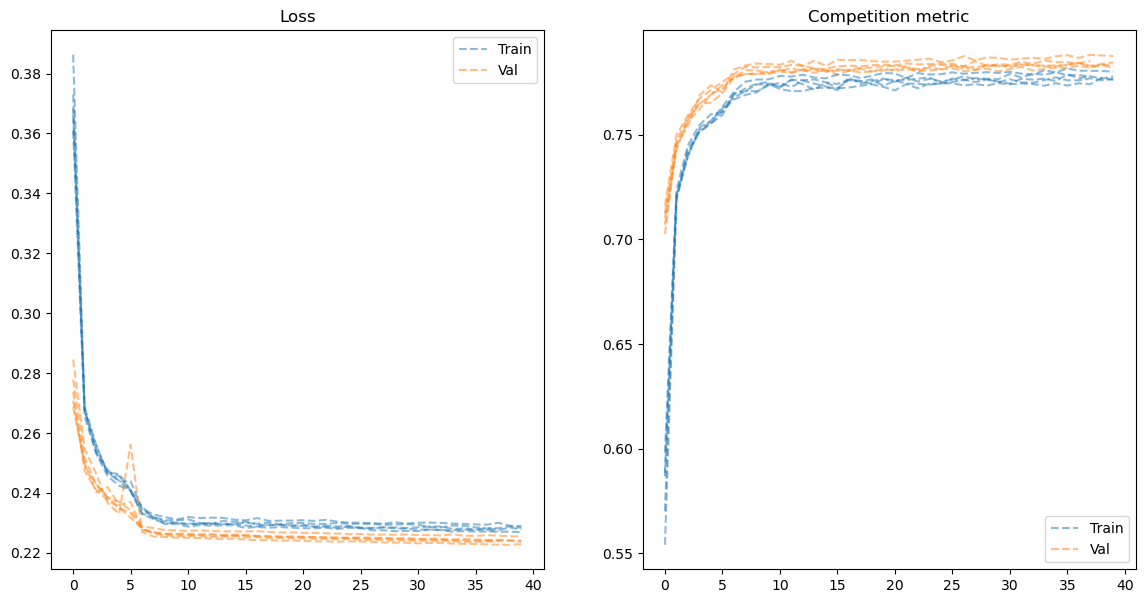

In [58]:
fig, axs = plt.subplots(ncols = 2, figsize=(14, 7))

for i in range(5):
    axs[0].plot(history['train_loss'][i], alpha = 0.5,
            label = "Train" if i == 0 else None,
            color = 'tab:blue',
            linestyle = 'dashed')
    axs[0].plot(history['val_loss'][i], alpha = 0.5,
            label = "Val" if i == 0 else None,
            color = 'tab:orange',
            linestyle = 'dashed')
    
    axs[1].plot(history['train_amex_metric'][i], alpha = 0.5,
            label = "Train" if i == 0 else None,
            color = 'tab:blue',
            linestyle = 'dashed')
    axs[1].plot(history['val_amex_metric'][i], alpha = 0.5,
            label = "Val" if i == 0 else None,
            color = 'tab:orange',
            linestyle = 'dashed')
axs[0].set_title("Loss")
axs[1].set_title("Competition metric")
axs[0].legend()
axs[1].legend()
plt.show()

In [55]:
history

{'train_loss': [array([0.36594088, 0.26737999, 0.25568452, 0.24672707, 0.24634476,
         0.24079463, 0.23429693, 0.23192191, 0.23086073, 0.23080526,
         0.23114122, 0.23000033, 0.22970197, 0.23058782, 0.23035444,
         0.23037247, 0.2296898 , 0.2301008 , 0.22951177, 0.22990655,
         0.22999203, 0.22963891, 0.22961606, 0.22993701, 0.2296598 ,
         0.22967468, 0.22963367, 0.22934622, 0.2293956 , 0.22954227,
         0.22938427, 0.22861673, 0.22844645, 0.22911045, 0.22895838,
         0.22850228, 0.22808069, 0.22820702, 0.22885101, 0.22833486]),
  array([0.3684148 , 0.26753987, 0.25354037, 0.24773462, 0.24395424,
         0.24046245, 0.23312171, 0.23189376, 0.23039744, 0.23009397,
         0.22947352, 0.22974003, 0.2299465 , 0.22961109, 0.22966358,
         0.23012258, 0.22947099, 0.22904571, 0.22947511, 0.22883442,
         0.22943155, 0.22862902, 0.22908733, 0.22878072, 0.22893863,
         0.22833782, 0.22830096, 0.22846531, 0.22842206, 0.22829099,
         0.2284921

## Example torch model

In [4]:
df2 = cudf.read_parquet(os.path.join(dataset_dir, 'derived', 'splits', 'train_0.parquet'))

# look at average values for last 3 months
df_train = df2.groupby('customer_ID', sort=False).tail(3).groupby('customer_ID').mean()
df_train

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
-7948374999843709812,0.456345,5.000000,0.026282,1.004786,0.005375,0.104417205,0.055832,0.008278,<NA>,0.1532619,...,-1.0,-1.0,0.000000,0.0,0.000000,<NA>,0.000000,0.006185,0.000000,0.0
-8645856538965131241,0.756145,6.000000,0.721992,0.293841,0.006862,0.597289562,0.000000,0.012906,0.020493843,<NA>,...,-1.0,-1.0,-0.333333,0.0,0.000000,<NA>,-0.333333,0.007025,-0.333333,0.0
-8791650985376527784,0.902983,0.000000,0.015144,1.006431,0.005585,-0.04807209,0.000000,0.005553,<NA>,<NA>,...,-1.0,-1.0,0.000000,0.0,0.000000,<NA>,0.000000,0.004280,0.000000,0.0
-8454268923601939076,0.823955,10.000000,0.029923,1.006844,0.002948,0.080841521,0.000000,0.009003,<NA>,0.01998057,...,-1.0,-1.0,0.000000,0.0,0.000000,<NA>,0.000000,0.006056,0.000000,0.0
-7657899299564496661,0.704843,8.666667,0.010633,0.939805,0.006357,0.090517749,0.000000,0.010066,0.023059726,<NA>,...,-1.0,-1.0,1.000000,0.0,0.862662,0.057864944,1.000000,0.007062,4.333333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-8713127797801704272,0.485146,6.333333,0.458467,0.024092,0.172573,0.283588727,0.000000,0.549716,<NA>,0.019031034,...,-1.0,-1.0,0.000000,0.0,0.000000,<NA>,0.000000,0.004491,0.000000,0.0
-7807490439052895278,0.815616,0.000000,0.004466,0.814304,0.004319,0.413618008,0.000000,0.005084,<NA>,0.01740142,...,-1.0,-1.0,1.000000,0.0,0.985106,0.573939919,1.000000,0.760147,2.000000,0.0
-8686894840230819858,0.385107,7.000000,0.024687,1.006793,0.003685,0.136240949,0.000000,0.005758,<NA>,0.058567395,...,-1.0,-1.0,0.000000,0.0,0.000000,<NA>,0.000000,0.005170,0.000000,0.0


In [5]:
X_train = torch.tensor(df_train.fillna(0.5).iloc[:, :(df_train.shape[1] - 1)].values, dtype = torch.float32)

In [6]:
y_train = torch.tensor(df_train.target, dtype=torch.float32)

In [7]:
class ExampleNet(nn.Module):
    
    def __init__(self):
        super(ExampleNet, self).__init__()
        
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        
        return x
    
mod = ExampleNet()
mod

ExampleNet(
  (fc1): Linear(in_features=188, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:
criterion = nn.BCEWithLogitsLoss()
train_dat = torch.utils.data.DataLoader(torch.hstack((X_train, y_train.unsqueeze(1))), batch_size = 64)
optim = torch.optim.Adam(mod.parameters(), lr = 0.001)


def train_one_epoch(epoch_index):
    running_loss = 0.
    num_batches = 0
    
    
    for i, data in enumerate(train_dat):
        inputs, labels = data[:, :-1], data[:, -1]
        inputs = inputs.to('cuda')
        labels = labels.unsqueeze(1).to('cuda')
        
        optim.zero_grad()
        
        out = mod(inputs)
        
        loss = criterion(out, labels)
        loss.backward()
        
        optim.step()
        
        # Gather data and report
        running_loss += loss.item()
        num_batches += 1
    
    return running_loss / num_batches

# move everything to the GPU
mod = mod.to('cuda')

In [9]:
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    mod.train(True)
    avg_loss = train_one_epoch(epoch_number)
    print(avg_loss)

    epoch_number += 1

EPOCH 1:
0.32613843656599023
EPOCH 2:
0.26247388131210897
EPOCH 3:
0.2575088815042401
EPOCH 4:
0.2529879827285834
EPOCH 5:
0.2500592030268318


In [11]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [18]:
mod.train(False)

y_target_all = None
y_pred_all = None

for dat in train_dat:
    X_train, y_train = dat[:, :-1], dat[:, -1].unsqueeze(1)
    X_train = X_train.to('cuda')
    y_train = y_train.to('cuda')
    
    y_pred = torch.sigmoid(mod(X_train))
    
    if y_target_all is None:
        y_target_all = y_train.to('cpu').squeeze(1)
        y_pred_all = y_pred.to('cpu').squeeze(1)
    else:
        y_target_all = torch.hstack([y_target_all, y_train.squeeze(1).to('cpu')])
        y_pred_all = torch.hstack([y_pred_all, y_pred.squeeze(1).to('cpu')])

In [24]:
y_true = pd.DataFrame({'target' : y_target_all.detach().numpy()})
y_pred = pd.DataFrame({'prediction' : y_pred_all.detach().numpy()})

amex_metric(y_true, y_pred)

0.7600681393020587

## Example preprocessing code

The below code is taken from the example processing of the training data, by Chris Deotte, on their [TensorFlow GRU Starter](https://www.kaggle.com/code/cdeotte/tensorflow-gru-starter-0-790) kaggle discussion post.

TODO: look at the below code and change accordingly...
also figure out how to do this withou `cudf`, the improved dataframe library...
Consider if need this library later when getting on to the preprocessing methods...

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE FILE
def get_rows(customers, train, NUM_FILES = 10, verbose = ''):
    chunk = len(customers)//NUM_FILES
    if verbose != '':
        print(f'We will split {verbose} data into {NUM_FILES} separate files.')
        print(f'There will be {chunk} customers in each file (except the last file).')
        print('Below are number of rows in each file:')
    rows = []

    for k in range(NUM_FILES):
        if k==NUM_FILES-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = train.loc[train.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows

if PROCESS_DATA:
    NUM_FILES = 10
    rows = get_rows(customers, train, NUM_FILES = NUM_FILES, verbose = 'train')

In [ ]:
def feature_engineer(train, PAD_CUSTOMER_TO_13_ROWS = True, targets = None):
        
    # REDUCE STRING COLUMNS 
    # from 64 bytes to 8 bytes, and 10 bytes to 3 bytes respectively
    train['customer_ID'] = train['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    train.S_2 = cudf.to_datetime( train.S_2 )
    train['year'] = (train.S_2.dt.year-2000).astype('int8')
    train['month'] = (train.S_2.dt.month).astype('int8')
    train['day'] = (train.S_2.dt.day).astype('int8')
    del train['S_2']
        
    # LABEL ENCODE CAT COLUMNS (and reduce to 1 byte)
    # with 0: padding, 1: nan, 2,3,4,etc: values
    d_63_map = {'CL':2, 'CO':3, 'CR':4, 'XL':5, 'XM':6, 'XZ':7}
    train['D_63'] = train.D_63.map(d_63_map).fillna(1).astype('int8')

    d_64_map = {'-1':2,'O':3, 'R':4, 'U':5}
    train['D_64'] = train.D_64.map(d_64_map).fillna(1).astype('int8')
    
    CATS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
    OFFSETS = [2,1,2,2,3,2,3,2,2] #2 minus minimal value in full train csv
    # then 0 will be padding, 1 will be NAN, 2,3,4,etc will be values
    for c,s in zip(CATS,OFFSETS):
        train[c] = train[c] + s
        train[c] = train[c].fillna(1).astype('int8')
    CATS += ['D_63','D_64']
    
    # ADD NEW FEATURES HERE
    # EXAMPLE: train['feature_189'] = etc etc etc
    # EXAMPLE: train['feature_190'] = etc etc etc
    # IF CATEGORICAL, THEN ADD TO CATS WITH: CATS += ['feaure_190'] etc etc etc
    
    # REDUCE MEMORY DTYPE
    SKIP = ['customer_ID','year','month','day']
    for c in train.columns:
        if c in SKIP: continue
        if str( train[c].dtype )=='int64':
            train[c] = train[c].astype('int32')
        if str( train[c].dtype )=='float64':
            train[c] = train[c].astype('float32')
            
    # PAD ROWS SO EACH CUSTOMER HAS 13 ROWS
    if PAD_CUSTOMER_TO_13_ROWS:
        tmp = train[['customer_ID']].groupby('customer_ID').customer_ID.agg('count')
        more = cupy.array([],dtype='int64') 
        for j in range(1,13):
            i = tmp.loc[tmp==j].index.values
            more = cupy.concatenate([more,cupy.repeat(i,13-j)])
        df = train.iloc[:len(more)].copy().fillna(0)
        df = df * 0 - 1 #pad numerical columns with -1
        df[CATS] = (df[CATS] * 0).astype('int8') #pad categorical columns with 0
        df['customer_ID'] = more
        train = cudf.concat([train,df],axis=0,ignore_index=True)
        
    # ADD TARGETS (and reduce to 1 byte)
    if targets is not None:
        train = train.merge(targets,on='customer_ID',how='left')
        train.target = train.target.astype('int8')
        
    # FILL NAN
    train = train.fillna(-0.5) #this applies to numerical columns
    
    # SORT BY CUSTOMER THEN DATE
    train = train.sort_values(['customer_ID','year','month','day']).reset_index(drop=True)
    train = train.drop(['year','month','day'],axis=1)
    
    # REARRANGE COLUMNS WITH 11 CATS FIRST
    COLS = list(train.columns[1:])
    COLS = ['customer_ID'] + CATS + [c for c in COLS if c not in CATS]
    train = train[COLS]
    
    return train

In [ ]:
if PROCESS_DATA:
    # CREATE PROCESSED TRAIN FILES AND SAVE TO DISK        
    for k in range(NUM_FILES):

        # READ CHUNK OF TRAIN CSV FILE
        skip = int(np.sum( rows[:k] ) + 1) #the plus one is for skipping header
        train = cudf.read_csv('../input/amex-default-prediction/train_data.csv', nrows=rows[k], 
                              skiprows=skip, header=None, names=T_COLS)

        # FEATURE ENGINEER DATAFRAME
        train = feature_engineer(train, targets = targets)

        # SAVE FILES
        print(f'Train_File_{k+1} has {train.customer_ID.nunique()} customers and shape',train.shape)
        tar = train[['customer_ID','target']].drop_duplicates().sort_index()
        if not os.path.exists(PATH_TO_DATA): os.makedirs(PATH_TO_DATA)
        tar.to_parquet(f'{PATH_TO_DATA}targets_{k+1}.pqt',index=False)
        data = train.iloc[:,1:-1].values.reshape((-1,13,188))
        cupy.save(f'{PATH_TO_DATA}data_{k+1}',data.astype('float32'))

    # CLEAN MEMORY
    del train, tar, data
    del targets
    gc.collect()